# **Machine Learning using scikit-learn**

This notebook demonstrates the usage of pipelines to promote best practices for Machine Learning in Python. As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use Allison Horst's Palmer Penguins dataset, available here: https://github.com/allisonhorst/palmerpenguins.

The dataset contains data on 344 penguins. There are three different species of penguins in the dataset, collected from three separate islands in the Palmer Archipelago, Antarctica. 

In [2]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [3]:
penguins = pd.read_csv('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv')
display(penguins.head())
penguins.info()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


In [4]:
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

## Data cleaning and EDA

We can now explore our data. We leave this exercise to the reader. For now, we can observe that there are a few NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop. For now, we'll just drop all of the sex NAs out of the dataframe.

In [5]:
penguins = penguins.dropna(subset=['sex'])
penguins.shape

(333, 8)

In [6]:
class_column = 'sex'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(penguins.drop(columns=class_column), penguins[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=penguins[class_column])

Quick sanity check to make sure that everything seems correct:

In [7]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (249, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
101,Adelie,Biscoe,41.0,20.0,203.0,4725.0,2009
260,Gentoo,Biscoe,43.3,14.0,208.0,4575.0,2009
142,Adelie,Dream,32.1,15.5,188.0,3050.0,2009
155,Gentoo,Biscoe,50.0,15.2,218.0,5700.0,2007
136,Adelie,Dream,35.6,17.5,191.0,3175.0,2009



On X test: 
X test dimensions:  (84, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
308,Chinstrap,Dream,42.5,16.7,187.0,3350.0,2008
120,Adelie,Torgersen,36.2,17.2,187.0,3150.0,2009
206,Gentoo,Biscoe,46.5,14.4,217.0,4900.0,2008
106,Adelie,Biscoe,38.6,17.2,199.0,3750.0,2009
99,Adelie,Dream,43.2,18.5,192.0,4100.0,2008


In [8]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (249,)


101      male
260    female
142    female
155      male
136    female
Name: sex, dtype: object


On y test: 
y test dimensions:  (84,)


308    female
120    female
206    female
106    female
99       male
Name: sex, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [9]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [10]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [11]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f915161f8e0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f915161fd00>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [12]:
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [13]:
tuning_grid

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f915161f8e0>),
                                                                        ('num_pipe',
                                                    

In [15]:
print(grid_search.best_score_)
grid_search.best_params_

0.9158367346938775


{'mdl__C': 316.22776601683796, 'mdl__l1_ratio': 0.0}

In [16]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009247,0.002797,0.003813,0.000611,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.90,0.90,0.92,...,0.903673,0.014628,11,0.899497,0.904523,0.909548,0.909548,0.910,0.906623,0.004091
1,0.007080,0.000218,0.003221,0.000043,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.90,0.90,0.92,...,0.899673,0.021619,13,0.889447,0.914573,0.909548,0.914573,0.900,0.905628,0.009684
2,0.007247,0.000518,0.003554,0.000338,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.92,0.88,0.90,...,0.899837,0.039756,12,0.894472,0.904523,0.889447,0.909548,0.900,0.899598,0.007109
3,0.007656,0.000529,0.003442,0.000253,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.92,0.88,0.90,...,0.895673,0.022995,14,0.904523,0.909548,0.909548,0.909548,0.885,0.903633,0.009518
4,0.006742,0.000031,0.003197,0.000047,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.88,0.88,0.90,...,0.891673,0.015432,15,0.904523,0.884422,0.899497,0.899497,0.885,0.894588,0.008273
5,0.007087,0.000135,0.003065,0.000121,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
6,0.008613,0.000718,0.003789,0.000424,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
7,0.008001,0.000517,0.003225,0.000164,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
8,0.007969,0.000390,0.003313,0.000160,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
9,0.007873,0.000351,0.003419,0.000267,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062


## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [17]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f918067bca0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [18]:
grid_search.classes_

array(['female', 'male'], dtype=object)

In [19]:
vip = grid_search.best_estimator_['mdl'].coef_[0]
vip

array([ 3.58742661, -2.44096235, -1.47526429, -0.40053606,  0.36492767,
       -0.29319164,  2.63847347,  3.12842385, -0.12627949,  3.99457647,
        0.1618589 ])

/Users/chaudhu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


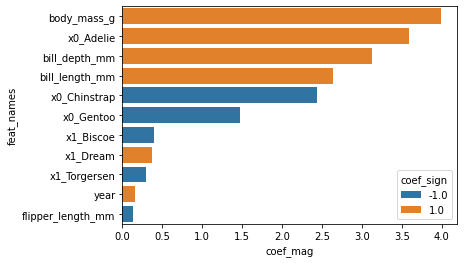

In [20]:
#get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [21]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

      female       0.89      0.93      0.91        42
        male       0.93      0.88      0.90        42

    accuracy                           0.90        84
   macro avg       0.91      0.90      0.90        84
weighted avg       0.91      0.90      0.90        84



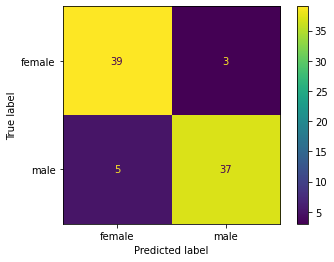

In [22]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

plt.show()

## Try it yourself!

Now that we've seen the power of pipelines in sklearn, let's now try implementing our own pipelines.

In [23]:
# Try implementing a pipeline where we use median imputation for numeric columns instead of mean imputation.

#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scale_num', StandardScaler())])

#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

With this new pipeline, now train a Random Forest model. Refer to the documentation for the parameters for the random forest classifier here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Is the performance better? 

In [24]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier())])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe4f0>)])),
                ('mdl', RandomForestClassifier())])

Now perform cross validation and modify the n_estimators parameter to values of [100, 200,500] and max_depth parameter to values of [10,15,50] for the random forest classifier for hyperparameter tuning.

In [25]:
tuning_grid = {'mdl__n_estimators' : [100, 200 ,500],
               'mdl__max_depth': [10, 15, 20] }
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [26]:
tuning_grid

{'mdl__n_estimators': [100, 200, 500], 'mdl__max_depth': [10, 15, 20]}

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                                        ('num_pipe',
                                                    

In [28]:
print(grid_search.best_score_)
grid_search.best_params_

0.9318367346938775


{'mdl__max_depth': 15, 'mdl__n_estimators': 100}

In [29]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__max_depth,param_mdl__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.099195,0.010119,0.010914,0.000301,10,100,"{'mdl__max_depth': 10, 'mdl__n_estimators': 100}",0.86,0.90,0.92,...,0.903918,0.044403,9,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.180623,0.005117,0.017245,0.000293,10,200,"{'mdl__max_depth': 10, 'mdl__n_estimators': 200}",0.90,0.92,0.94,...,0.919918,0.039878,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.443289,0.006293,0.038108,0.001062,10,500,"{'mdl__max_depth': 10, 'mdl__n_estimators': 500}",0.92,0.92,0.94,...,0.923837,0.026313,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.091998,0.001687,0.010484,0.000273,15,100,"{'mdl__max_depth': 15, 'mdl__n_estimators': 100}",0.90,0.92,0.96,...,0.931837,0.023811,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.170356,0.002910,0.016393,0.000178,15,200,"{'mdl__max_depth': 15, 'mdl__n_estimators': 200}",0.86,0.90,0.94,...,0.911918,0.042953,7,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.443611,0.010228,0.040326,0.001780,15,500,"{'mdl__max_depth': 15, 'mdl__n_estimators': 500}",0.90,0.92,0.94,...,0.919918,0.039878,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.097959,0.001805,0.011132,0.000390,20,100,"{'mdl__max_depth': 20, 'mdl__n_estimators': 100}",0.90,0.90,0.92,...,0.911918,0.039050,7,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.189836,0.005878,0.018555,0.000298,20,200,"{'mdl__max_depth': 20, 'mdl__n_estimators': 200}",0.86,0.92,0.96,...,0.915837,0.040617,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,0.461484,0.011855,0.040725,0.002199,20,500,"{'mdl__max_depth': 20, 'mdl__n_estimators': 500}",0.88,0.92,0.94,...,0.919837,0.028054,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [30]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91807fdd30>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
               

In [31]:
grid_search.classes_

array(['female', 'male'], dtype=object)

In [32]:
vip = grid_search.best_estimator_['mdl'].feature_importances_
vip

array([0.02545891, 0.01549861, 0.0135213 , 0.01405479, 0.00570057,
       0.0069946 , 0.20536698, 0.28284418, 0.10238198, 0.30530746,
       0.02287062])

/Users/chaudhu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


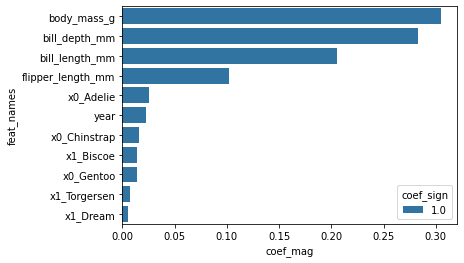

In [33]:
#get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

In [34]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

      female       0.91      0.95      0.93        42
        male       0.95      0.90      0.93        42

    accuracy                           0.93        84
   macro avg       0.93      0.93      0.93        84
weighted avg       0.93      0.93      0.93        84



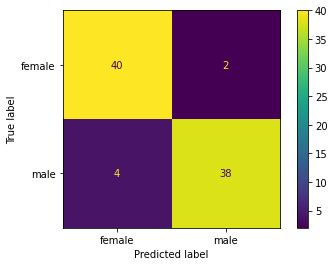

In [35]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

plt.show()

# GBM

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', GradientBoostingClassifier())])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe4f0>)])),
                ('mdl', GradientBoostingClassifier())])

In [37]:
tuning_grid = {'mdl__n_estimators' : [100, 200 ,500],
               'mdl__max_depth': [10, 15, 20],
               'mdl__learning_rate': [1.0, 0.5],
               'mdl__random_state' : [0]}
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [38]:
tuning_grid

{'mdl__n_estimators': [100, 200, 500],
 'mdl__max_depth': [10, 15, 20],
 'mdl__learning_rate': [1.0, 0.5],
 'mdl__random_state': [0]}

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                                        ('num_pipe',
                                                    

In [40]:
print(grid_search.best_score_)
grid_search.best_params_

0.895673469387755


{'mdl__learning_rate': 0.5,
 'mdl__max_depth': 10,
 'mdl__n_estimators': 100,
 'mdl__random_state': 0}

In [41]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__learning_rate,param_mdl__max_depth,param_mdl__n_estimators,param_mdl__random_state,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.045052,0.004997,0.004129,0.000475,1.0,10,100,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.875755,0.033954,16,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.053104,0.001907,0.003364,0.000141,1.0,10,200,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.875755,0.033954,16,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.112893,0.006489,0.003795,0.000126,1.0,10,500,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.875755,0.033954,16,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.041133,0.002467,0.004133,0.000307,1.0,15,100,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.060481,0.002493,0.003871,0.000218,1.0,15,200,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.117588,0.003189,0.004128,0.000361,1.0,15,500,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.043249,0.001152,0.004141,0.000192,1.0,20,100,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.062038,0.003201,0.003924,0.000257,1.0,20,200,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,0.116331,0.003307,0.003861,0.000141,1.0,20,500,0,"{'mdl__learning_rate': 1.0, 'mdl__max_depth': ...",0.84,...,0.891755,0.040899,10,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,0.053051,0.003411,0.004007,0.000314,0.5,10,100,0,"{'mdl__learning_rate': 0.5, 'mdl__max_depth': ...",0.86,...,0.895673,0.031761,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [42]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9170aab910>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
               

# Light-GBM

In [45]:
import lightgbm

In [46]:
from lightgbm import LGBMClassifier

In [48]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LGBMClassifier())])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe4f0>)])),
                ('mdl', LGBMClassifier())])

In [52]:
tuning_grid = {'mdl__num_leaves' : [10, 20, 30],
               'mdl__random_state' : [0]}
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [53]:
tuning_grid

{'mdl__num_leaves': [10, 20, 30], 'mdl__random_state': [0]}

In [54]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f91217fe6d0>),
                                                                        ('num_pipe',
                                                    

In [55]:
print(grid_search.best_score_)
grid_search.best_params_

0.8995918367346938


{'mdl__num_leaves': 10, 'mdl__random_state': 0}